In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth',100)

## This file helps you plot more efficiently
feel free to contact me(yl3963@columbia.edu) if you have any questions


## prepare dataset

In [2]:
twitter1 = pd.read_csv("trayvontweets/Trayvon Tweets 2012.csv",encoding = "latin1", index_col = 0)

/Users/ycr/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ycr/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
twitter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
id                      1048575 non-null int64
message_id              1048575 non-null int64
user_handle             1048571 non-null object
orig_user_id            1048575 non-null int64
orig_user_handle        1048575 non-null object
topsy_type              1048575 non-null object
orig_date_posted_gmt    1048575 non-null float64
date_posted_gmt         1048575 non-null float64
message                 1048073 non-null object
orig_user_location      1048575 non-null object
coordinates             7480 non-null object
tweet_location          12540 non-null object
longitude               7480 non-null float64
latitude                7480 non-null float64
created_at_gmt          167805 non-null float64
seconds_after_event     1047893 non-null float64
FIPS                    1048575 non-null object
County                  1048573 non-null object
City                    1043351 

In [4]:
data_msg_time = twitter1.loc[twitter1['message'].isnull() == False,['date_posted_gmt','message']]

In [5]:
data_msg_time = data_msg_time.sample(n = 100000,random_state=0)
data_msg_time = data_msg_time.reset_index(drop = True)

In [6]:
def date(dates):
    delta=datetime.timedelta(days=dates)
    today=datetime.datetime.strptime('1899-12-30 00:00:00','%Y-%m-%d %H:%M:%S')+delta
    return datetime.datetime.strftime(today,'%Y-%m-%d %H:%M:%S')

In [7]:
data_msg_time['date_posted_gmt'] = data_msg_time['date_posted_gmt'].apply(lambda x: date(x))

In [8]:
data_msg_time.head()

,date_posted_gmt,message
0,2012-09-02 04:50:13,UT Martin makes 43 yard FG with 4 seconds left to take 20-17 lead.
1,2012-03-25 17:10:30,"No Trayvon's death has NOTHING on emmett till's, BUT the murders both had the Same Moral Behind ..."
2,2013-02-25 23:57:20,Ready for spring break
3,2013-02-16 03:01:49,Just landed in Los Angeles for Real Time with Bill Maher on @HBO. @billmaher's special guest is ...
4,2012-04-23 15:27:27,"RIP Trayvon, you're in a better place.."


###  add year month day week days_from_event columns for original dataframe

In [9]:
def add_ymdw(df):
    df['date']=pd.to_datetime(df['date_posted_gmt'])

    df['year']=df['date'].apply(lambda x: x.year)

    df['month']=df['date'].apply(lambda x: x.month)

    df['day']=df['date'].apply(lambda x: x.day)
    
    def getweek(a,b,c):
        return datetime.date(a,b,c).isocalendar()[1]
    df['week'] = df.apply(lambda x: getweek(x['year'], x['month'],x['day']), axis=1)
    
    return df

In [10]:
data_msg_time=add_ymdw(data_msg_time)

In [11]:
event_date = '20120226'
data_msg_time['days_from_event'] = data_msg_time.apply(lambda x: (x['date'] - pd.to_datetime(event_date)).days, axis=1)


### split dataset according to their year
you can get 3 dataframes finally

In [12]:
def split_year(df):
    df2012=df[df['year']==2012]
    df2013=df[df['year']==2013]
    df2014=df[df['year']==2014]
    return df2012,df2013,df2014

In [13]:
data_msg_time2012,data_msg_time2013,data_msg_time2014=split_year(data_msg_time)
data_msg_time2012.head()

,date_posted_gmt,message,date,year,month,day,week,days_from_event
0,2012-09-02 04:50:13,UT Martin makes 43 yard FG with 4 seconds left to take 20-17 lead.,2012-09-02 04:50:13,2012,9,2,35,189
1,2012-03-25 17:10:30,"No Trayvon's death has NOTHING on emmett till's, BUT the murders both had the Same Moral Behind ...",2012-03-25 17:10:30,2012,3,25,12,28
4,2012-04-23 15:27:27,"RIP Trayvon, you're in a better place..",2012-04-23 15:27:27,2012,4,23,17,57
5,2012-05-12 14:53:44,AG Brondi just acknowledges Geraldo Rivera as her personal friend. Ma'am this is the school that...,2012-05-12 14:53:44,2012,5,12,19,76
6,2012-04-11 20:17:40,BREAKING NEWS: George Zimmerman WILL be charged the murder of Trayvon Martin http://t.co/J6a0mqzz,2012-04-11 20:17:40,2012,4,11,15,45


### preprocess message

In [14]:
#change all to lower case for future regex
data_msg_time2012['message'] = data_msg_time2012['message'].str.lower()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## detect emotions

### import LIWC dictionary

In [15]:
file = open("LIWC Dictionary/LIWC_dic.txt","r")

LIWC = file.readlines()
LIWC_dict = {}
for line in LIWC:
    line = line.split(',')
    category = line[0]
    words = line[1:]
    words[0] = words[0][1:]
    words[-1] = words[-1][:-2]
    LIWC_dict[category] = words

In [16]:
LIWC_dict.keys()

dict_keys(['Function', 'Pronoun', 'Ppron', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'Compare', 'Interrog', 'Number', 'Quant', 'Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Social', 'Family', 'Friend', 'Female', 'Male', 'CogProc', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Percept', 'See', 'Hear', 'Feel', 'Bio', 'Body', 'Health', 'Sexual', 'Ingest', 'Drives', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'FocusPast', 'FocusPresent', 'FocusFuture', 'Relativ', 'Motion', 'Space', 'Time', 'Work', 'Leisure', 'Home', 'Money', 'Relig', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Stress'])

### Adjust LIWC dictionary

In [17]:
posemo = LIWC_dict['Posemo']
for i in range(len(posemo)):
    if posemo[i][-1] == '*':
        posemo[i] = r'\b' + posemo[i][:-1]
    else:
        posemo[i] = r'\b' + posemo[i] + r'\b'
posemo[0] = '\(:'
posemo[5] = ':\)'
reg_posemo = "|".join(posemo)
reg_posemo = re.compile(reg_posemo)

In [18]:
negemo = LIWC_dict['Negemo']
for i in range(len(negemo)):
    if negemo[i][-1] == '*':
        negemo[i] = r'\b' + negemo[i][:-1]
    else:
        negemo[i] = r'\b' + negemo[i] + r'\b'
negemo[0] = '\):'
negemo[5] = ':\('
reg_negemo = "|".join(negemo)
reg_negemo = re.compile(reg_negemo)

In [19]:
anx = LIWC_dict['Anx']
for i in range(len(anx)):
    if anx[i][-1] == '*':
        anx[i] = r'\b' + anx[i][:-1]
    else:
        anx[i] = r'\b' + anx[i] + r'\b'
reg_anx = "|".join(anx)
reg_anx = re.compile(reg_anx)

In [20]:
anger = LIWC_dict['Anger']
for i in range(len(anger)):
    if anger[i][-1] == '*':
        anger[i] = r'\b' + anger[i][:-1]
    else:
        anger[i] = r'\b' + anger[i] + r'\b'
reg_anger = "|".join(anger)
reg_anger = re.compile(reg_anger)

In [21]:
sad = LIWC_dict['Sad']
for i in range(len(sad)):
    if sad[i][-1] == '*':
        sad[i] = r'\b' + sad[i][:-1]
    else:
        sad[i] = r'\b' + sad[i] + r'\b'
reg_sad = "|".join(sad)
reg_sad = re.compile(reg_sad)

In [22]:
stress = LIWC_dict['Stress']
for i in range(len(stress)):
    if stress[i][-1] == '*':
        stress[i] = r'\b' + stress[i][:-1]
    else:
        stress[i] = r'\b' + stress[i] + r'\b'
reg_stress = "|".join(stress)
reg_stress = re.compile(reg_stress)

In [23]:
reg_posemo.search("humorabc")

<re.Match object; span=(0, 5), match='humor'>

In [24]:
reg_posemo.search("happyhhh")

### function to check whether the message contains the category or not

In [25]:
def check_category(s,category,dic):
    '''
    s type: string
    category type: list of string 
    '''
    if category == 'Posemo':
        if reg_posemo.search(s):
            return category
    elif category == 'Negemo':
        if reg_negemo.search(s):
            return category
    elif category == 'Anx':
        if reg_anx.search(s):
            return category
    elif category == 'Anger':
        if reg_anger.search(s):
            return category
    elif category == 'Sad':
        if reg_sad.search(s):
            return category
    elif category == 'Stress':
        if reg_stress.search(s):
            return category
    else:
        print("only valid for six category")
    return 'NA'

In [26]:
check_category('stressed','Anx',LIWC_dict)

'Anx'

In [27]:
check_category('happy!!!','Anx',LIWC_dict)

'NA'

In [28]:
check_category('afraid','Negemo',LIWC_dict)

'Negemo'

In [29]:
check_category('confu','Negemo',LIWC_dict)

'NA'

### add_tag_col
- df:  dataframe 
- cate: list of emotion category
- dic: the dictionary stores all words belong to the category
e.g. here tag='Anx' means the message of the row contains anxiety words

In [30]:
def add_tag_col(df,cate,dic):
    for category in cate:
        df[category]=df.apply(lambda x: check_category(x['message'],category,dic),axis=1)
    return df

In [31]:
data_msg_time2012.head()

,date_posted_gmt,message,date,year,month,day,week,days_from_event
0,2012-09-02 04:50:13,ut martin makes 43 yard fg with 4 seconds left to take 20-17 lead.,2012-09-02 04:50:13,2012,9,2,35,189
1,2012-03-25 17:10:30,"no trayvon's death has nothing on emmett till's, but the murders both had the same moral behind ...",2012-03-25 17:10:30,2012,3,25,12,28
4,2012-04-23 15:27:27,"rip trayvon, you're in a better place..",2012-04-23 15:27:27,2012,4,23,17,57
5,2012-05-12 14:53:44,ag brondi just acknowledges geraldo rivera as her personal friend. ma'am this is the school that...,2012-05-12 14:53:44,2012,5,12,19,76
6,2012-04-11 20:17:40,breaking news: george zimmerman will be charged the murder of trayvon martin http://t.co/j6a0mqzz,2012-04-11 20:17:40,2012,4,11,15,45


In [32]:
emotions = ['Sad','Anx','Anger','Negemo','Posemo','Stress']
data_msg_time2012=add_tag_col(data_msg_time2012,emotions,LIWC_dict)  
data_msg_time2012.head()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_posted_gmt,message,date,year,month,day,week,days_from_event,Sad,Anx,Anger,Negemo,Posemo,Stress
0,2012-09-02 04:50:13,ut martin makes 43 yard fg with 4 seconds left to take 20-17 lead.,2012-09-02 04:50:13,2012,9,2,35,189,NA,NA,NA,NA,NA,NA
1,2012-03-25 17:10:30,"no trayvon's death has nothing on emmett till's, but the murders both had the same moral behind ...",2012-03-25 17:10:30,2012,3,25,12,28,NA,NA,Anger,Negemo,NA,NA
4,2012-04-23 15:27:27,"rip trayvon, you're in a better place..",2012-04-23 15:27:27,2012,4,23,17,57,NA,NA,NA,NA,Posemo,NA
5,2012-05-12 14:53:44,ag brondi just acknowledges geraldo rivera as her personal friend. ma'am this is the school that...,2012-05-12 14:53:44,2012,5,12,19,76,NA,NA,Anger,Negemo,NA,NA
6,2012-04-11 20:17:40,breaking news: george zimmerman will be charged the murder of trayvon martin http://t.co/j6a0mqzz,2012-04-11 20:17:40,2012,4,11,15,45,NA,NA,Anger,Negemo,NA,NA


## Plot emotions in 2012

In [33]:
df_all_week = data_msg_time2012.groupby('week')['message'].count()
df_all_week

week
1        23
8        28
9        48
10      159
11     1926
12    32369
13    23133
14     4729
15    11187
16     2932
17     1968
18      783
19      767
20     1945
21      632
22      944
23      543
24      968
25      812
26      459
27     1154
28      460
29     1473
30      472
31      255
32      294
33      342
34      244
35      585
36      267
37      305
38      321
39      161
40      181
41      189
42      391
43      203
44      173
45      253
46      238
47      146
48      313
49      506
50      200
51      229
52      165
Name: message, dtype: int64

Most of the data are from week 8. So we will plot from week 8.

### plot_count_trend function
- df: the dataframe contains at least **message,week, tag** cols

- cate: the category of emotion e.g. anxiety='anx

In [34]:
def plot_count_trend_week(df,category):
    df_category_week = pd.DataFrame()
    for cate in category:
        df_cate_week=df[df[cate]==cate].groupby('week')['message'].count()    
        df_cate_week = pd.DataFrame(df_cate_week)
        df_cate_week.columns = [cate]
        df_category_week = pd.concat([df_category_week,df_cate_week],axis = 1)
    plt.figure(figsize=(20,8))
    plt.xlabel('week in 2012',size=20)
    plt.ylabel('tweet num',size=20)
    # gca stands for 'get current axis'
    ax = plt.gca()
    df_category_week.plot(kind='line',ax=ax,fontsize=20)
    return df_category_week

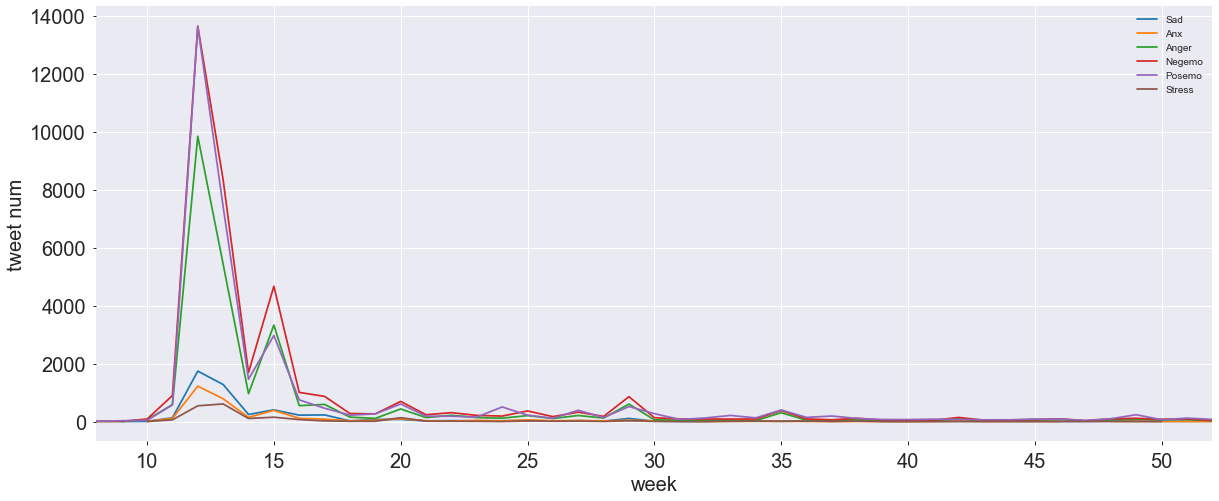

In [35]:
df_cate_week = plot_count_trend_week(data_msg_time2012.loc[data_msg_time2012['week']>=8],emotions)

### plot_fraction_trend
- df: the dataframe contains at least **message,week,tag cols**
- cate: the category of emotion e.g. anxiety='anx
- title: graph title
- xlabel: graph xlabel

In [36]:
df_all_week = pd.DataFrame(df_all_week)
df_cate_week = df_cate_week.join(df_all_week)
df_cate_week = df_cate_week.fillna(0)

In [37]:
for cate in  emotions:
    df_cate_week[cate] = df_cate_week[cate]/df_cate_week['message']*100
df_cate_week = df_cate_week.drop(columns='message')

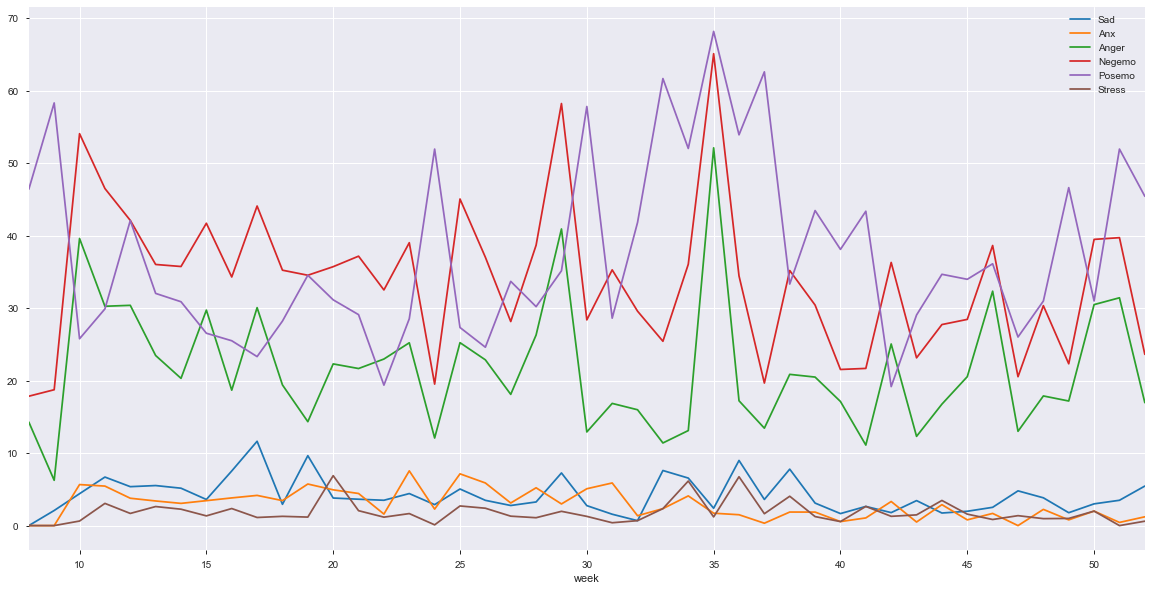

In [38]:
df_cate_week.plot(figsize=(20,10))

In [39]:
df_cate_week.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,0.297351,0.113271,0.320649,-0.097596,0.410416
Anx,0.297351,1.000000,0.263856,0.518358,-0.424826,0.222572
Anger,0.113271,0.263856,1.000000,0.907855,-0.178862,-0.057731
Negemo,0.320649,0.518358,0.907855,1.000000,-0.218341,0.147888
Posemo,-0.097596,-0.424826,-0.178862,-0.218341,1.000000,-0.000083
Stress,0.410416,0.222572,-0.057731,0.147888,-0.000083,1.000000


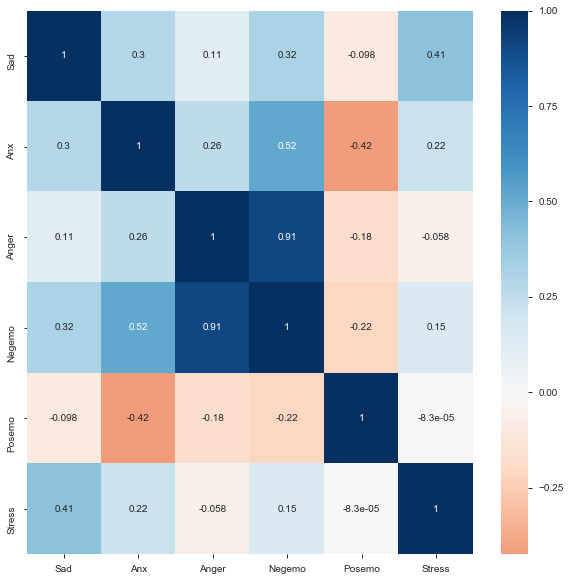

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cate_week.corr(),annot=True,center=0,cmap='RdBu')

## Plot emotions after events happened 90 days

In [41]:
def plot_count_trend_days(df,category):
    df_category_week = pd.DataFrame()
    for cate in category:
        df_cate_week=df[df[cate]==cate].groupby('days_from_event')['message'].count()    
        df_cate_week = pd.DataFrame(df_cate_week)
        df_cate_week.columns = [cate]
        df_category_week = pd.concat([df_category_week,df_cate_week],axis = 1)
    plt.figure(figsize=(20,8))
    plt.xlabel('days after event',size=20)
    plt.ylabel('tweet num',size=20)
    # gca stands for 'get current axis'
    ax = plt.gca()
    df_category_week.plot(kind='line',ax=ax,fontsize=20)
    return df_category_week

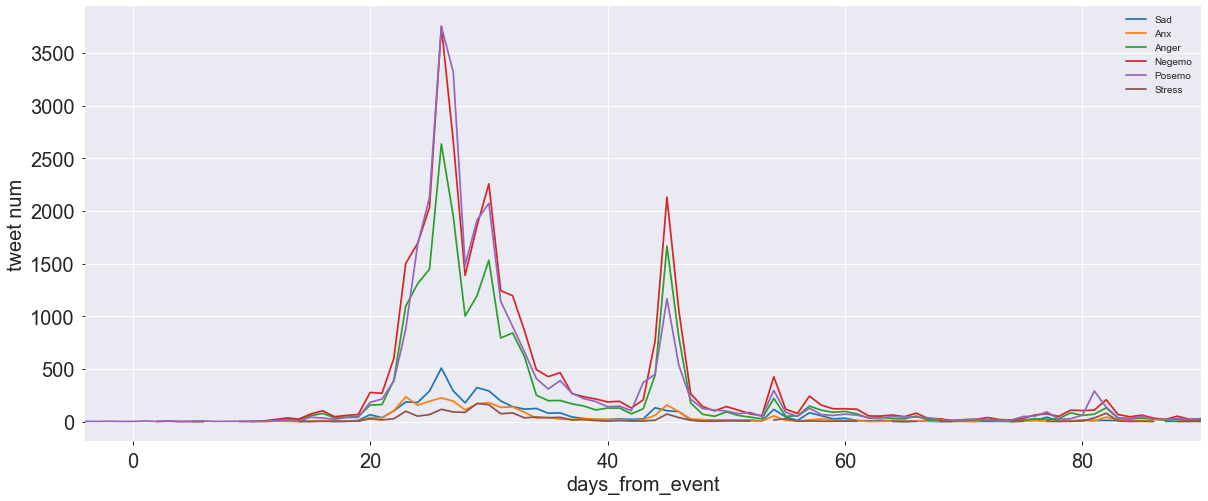

In [42]:
df_cate_days_narrow = plot_count_trend_days(data_msg_time2012.loc[(data_msg_time2012['days_from_event']<=90)],emotions)


In [43]:
df_all_days = data_msg_time2012.groupby('days_from_event')['message'].count()
df_all_days = pd.DataFrame(df_all_days)
df_cate_days_narrow = df_cate_days_narrow.join(df_all_days)
df_cate_days_narrow = df_cate_days_narrow.fillna(0)

In [44]:
for cate in  emotions:
    df_cate_days_narrow[cate] = df_cate_days_narrow[cate]/df_cate_days_narrow['message']*100
df_cate_days_narrow = df_cate_days_narrow.drop(columns='message')

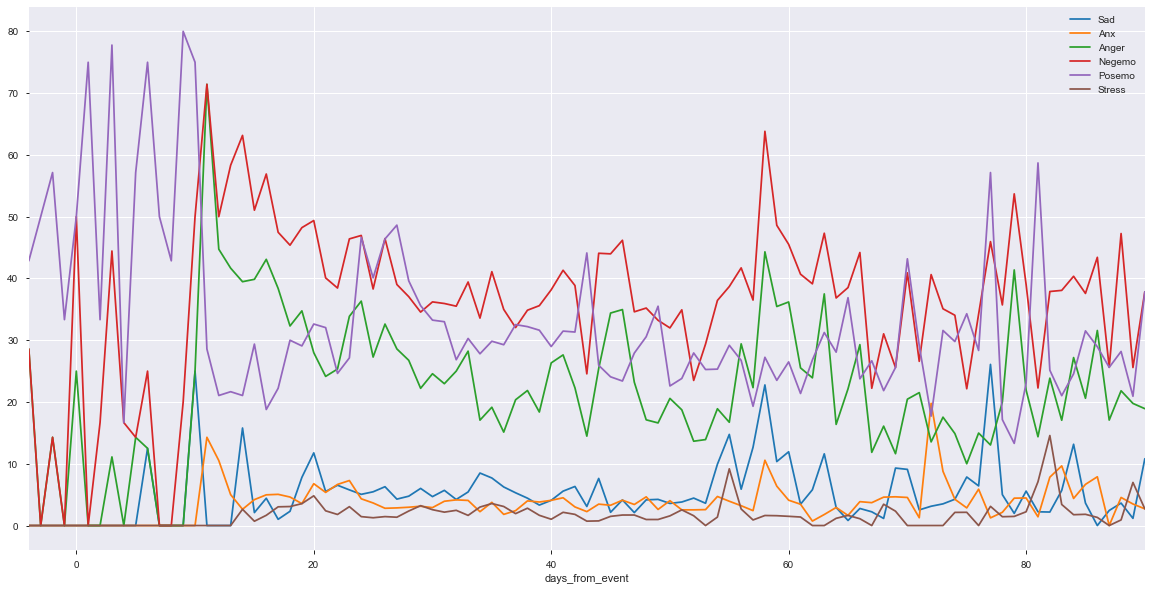

In [45]:
df_cate_days_narrow.plot(figsize=(20,10))

In [46]:
df_cate_days_narrow.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,0.055072,0.165355,0.382345,0.051536,0.163559
Anx,0.055072,1.000000,0.485991,0.518192,-0.476124,0.167456
Anger,0.165355,0.485991,1.000000,0.863507,-0.373576,0.076698
Negemo,0.382345,0.518192,0.863507,1.000000,-0.345710,0.136882
Posemo,0.051536,-0.476124,-0.373576,-0.345710,1.000000,-0.195502
Stress,0.163559,0.167456,0.076698,0.136882,-0.195502,1.000000


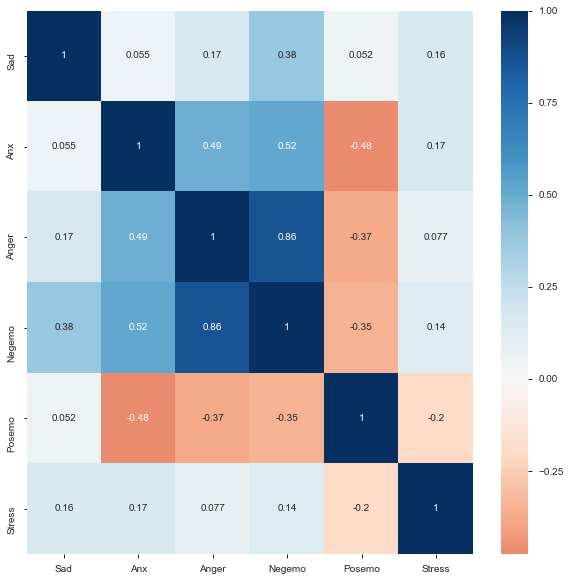

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cate_days_narrow.corr(),annot=True,center=0,cmap='RdBu')

**Only look at Posemo&Negemo**

In [48]:
df_cate_days_narrow = df_cate_days_narrow[['Posemo','Negemo']]

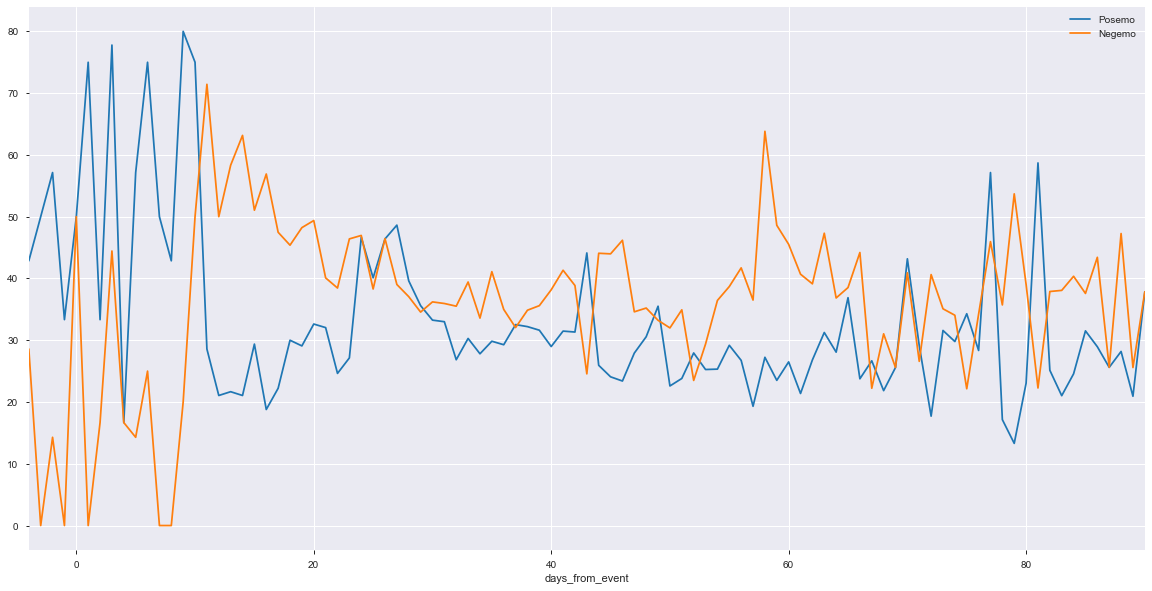

In [49]:
df_cate_days_narrow.plot(figsize=(20,10))

In [50]:
df_cate_days_narrow.corr()

,Posemo,Negemo
Posemo,1.00000,-0.34571
Negemo,-0.34571,1.00000
